# Spaceship Titanic (Cleaning)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style("darkgrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

#### Merging the Dataset
Original dataset is split into train and test - but for EDA purposes we need to combine them

In [5]:
test_and_sample = test.merge(sample, on='PassengerId')
spacetitanic = train.merge(test_and_sample, how='outer')

In [6]:
#If merge was succesful we should see nearly 13000 passengers
spacetitanic['PassengerId'].nunique()

12970

#### Peeping the Dataset

In [7]:
spacetitanic.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Cleaning and Modifying the Data: Checklist

* Investigate missing values

Amenities:
* NAN for amenities should be replaced with 0
* Combine amenities column and create new column called total spending
* Create category based on number of spending (Broke, Moderate, HeavySpender)

Cryosleep:
* True and False should be replaced with boolean

Passenger ID and Cabin:
* Splitting the passenger ID - Create a new column which consists of a category for solo,couple,three,nuclear,big_group
* Split Cabin into new columns (deck/num/side)

Age:
* Create Age category (Infant, kid, adult, etc.)

## Investigate Missing Values

In [8]:
spacetitanic.isnull().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
Transported       0
dtype: int64

## Amenities

In [9]:
#NaN for amenities should be replaced with 0
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
spacetitanic[amenities].fillna(0, inplace=True)

In [10]:
#Combine amenities column and create new column called total spending
spacetitanic['total_spending'] = spacetitanic['RoomService'] + spacetitanic['FoodCourt'] + spacetitanic['ShoppingMall'] + spacetitanic['Spa'] + spacetitanic['VRDeck']
spacetitanic['total_spending'].fillna(0, inplace = True)

Before we can create a category based on number of spending, we should investigate the distribution of the data.

In [11]:
spacetitanic['total_spending'].describe()

count    12970.000000
mean      1315.948034
std       2723.968925
min          0.000000
25%          0.000000
50%        637.000000
75%       1299.000000
max      35987.000000
Name: total_spending, dtype: float64

Coefficient of Variation: Standard deviation divided by Mean

In [12]:
spacetitanic['total_spending'].std() / spacetitanic['total_spending'].mean() 

2.0699669403588983

Since this CV value is greater than 1, it tells us that the standard deviation of the data values are quite high.

To get a better picture, let's take a look at the spread of the data.

In [13]:
spacetitanic['total_spending'].quantile([0.05,0.25,0.5,0.75,0.95])

0.05       0.0
0.25       0.0
0.50     637.0
0.75    1299.0
0.95    6137.0
Name: total_spending, dtype: float64

Boxplot to better visualize the percentile above:

<AxesSubplot:xlabel='total_spending'>

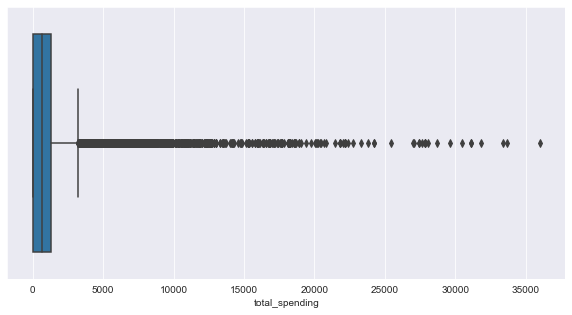

In [14]:
plt.figure(figsize = (10,5))
sns.boxplot(data=spacetitanic, x='total_spending')

Using a histogram to further illustrate the skew and spread:

<AxesSubplot:xlabel='total_spending', ylabel='Count'>

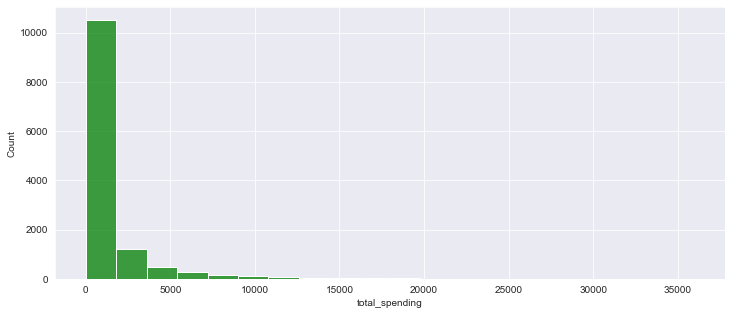

In [15]:
plt.figure(figsize = (12,5))
sns.histplot(data=spacetitanic, x='total_spending', bins=20, color='green')

Alright, it's now very clear that the total spending variable is very much skewed to the left. It is getting increasingly obvious that most of the passengers on the ship don't spend too much cash onboard, if any at all (I suspect the zero spenders are in cryosleep), as opposed to a little minority splashing the cash. 

We should not get into any conclusions though, this is a good starting point because now we can investigate what makes a passenger spend lots of money in the first place. Is it because they are in VIP? Does it have anything to do with age, and so on, and so on.

We will now categorise spending levels based on the quantiles.

In [78]:
def get_spending_cat(x):
    if x == 0:
        return 'zero_spender'
    elif x < 729:
        return 'light_spender'
    elif x < 1463:
        return 'moderate_spender'
    else:
        return 'heavy_spender'
    
spacetitanic['spending_cat'] = spacetitanic['total_spending'].apply(get_spending_cat)

spacetitanic[['total_spending', 'spending_cat']].head(8)

,total_spending,spending_cat
0,0.0,zero_spender
1,736.0,moderate_spender
2,10383.0,heavy_spender
3,5176.0,heavy_spender
4,1091.0,moderate_spender
5,774.0,moderate_spender
6,1584.0,heavy_spender
7,0.0,zero_spender


## Cryo-Sleep Boolean Should Be Converted To Binary

In [17]:
def booleanConvert(x):
    if x == False:
        return 0
    elif x == True:
        return 1
    
spacetitanic['CryoSleepbool'] = spacetitanic['CryoSleep'].apply(booleanConvert)

spacetitanic[['CryoSleep', 'CryoSleepbool']].head(8)

,CryoSleep,CryoSleepbool
0,False,0.0
1,False,0.0
2,False,0.0
3,False,0.0
4,False,0.0
5,False,0.0
6,False,0.0
7,True,1.0


## Passenger ID and Cabin:
* Split Cabin into new columns (deck/num/side)

In [18]:
spacetitanic[['Deck', 'Num', 'Side']] = spacetitanic['Cabin'].str.split('/', expand=True)
spacetitanic[['Cabin', 'Deck', 'Num', 'Side']].head(7)

,Cabin,Deck,Num,Side
0,B/0/P,B,0,P
1,F/0/S,F,0,S
2,A/0/S,A,0,S
3,A/0/S,A,0,S
4,F/1/S,F,1,S
5,F/0/P,F,0,P
6,F/2/S,F,2,S


## Splitting The Passenger ID 
* Create a new column which consists of a category for solo,couple,three,nuclear,big_group

In [19]:
spacetitanic['PassengerId'].head()

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
Name: PassengerId, dtype: object

In [20]:
spacetitanic['Group'] = spacetitanic['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

spacetitanic['Group_size'] = spacetitanic['Group'].apply(lambda x: spacetitanic['Group'].value_counts()[x])

In [21]:
def get_group_cat(group):
    if group == 1:
        return 'solo'
    elif group == 2:
        return 'couple'
    elif group == 3:
        return 'three'
    elif group == 4:
        return 'nuclear'
    else:
        return 'big_group'
    
spacetitanic['Group_cat'] = spacetitanic['Group_size'].apply(get_group_cat)

In [22]:
spacetitanic[['PassengerId', 'Group', 'Group_size', 'Group_cat']].head(10)

,PassengerId,Group,Group_size,Group_cat
0,0001_01,1,1,solo
1,0002_01,2,1,solo
2,0003_01,3,2,couple
3,0003_02,3,2,couple
4,0004_01,4,1,solo
5,0005_01,5,1,solo
6,0006_01,6,2,couple
7,0006_02,6,2,couple
8,0007_01,7,1,solo
9,0008_01,8,3,three


In [23]:
spacetitanic['Group_size'].value_counts()

1    7145
2    2590
3    1506
4     616
5     380
7     329
6     252
8     152
Name: Group_size, dtype: int64

## Creating an Age Category:

In [24]:
def get_age_group(age):
    if age < 2:
        return 'Infant'
    elif age < 5:
        return 'Toddler'
    elif age < 12:
        return 'Kid'
    elif age < 23:
        return 'Youth'
    elif age < 58:
        return 'Adult'
    else:
        return 'Senior'
    
spacetitanic['Age_group'] = spacetitanic['Age'].apply(get_age_group)

spacetitanic[['Age', 'Age_group']].head(7)

,Age,Age_group
0,39.0,Adult
1,24.0,Adult
2,58.0,Senior
3,33.0,Adult
4,16.0,Youth
5,44.0,Adult
6,26.0,Adult


### Exporting the CSV File 

In [101]:
spacetitanic.to_csv('spacetitanic.csv')

----------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------

# Exploratory Data Analysis
The purpose of this Dataset is to investigate who got transported into an alternate dimension. Therefore, the EDA will primarily look into transported/not when pitted against the other variables. However, an initial look into the other variables will be done to get a sense of what the distribution looks like. 

## Section 1: Visualizing Variables

### How many people were transported vs. not transported?

In [27]:
spacetitanic['Transported'].value_counts()

False    8592
True     4378
Name: Transported, dtype: int64

In [72]:
transportedMask = spacetitanic['Transported'] == True
transportedNum = len(spacetitanic[transportedMask])

notTransportedMask = spacetitanic['Transported'] == False
notTransportedNum = len(spacetitanic[notTransportedMask])

print(f"The difference between Not Transported and Transported is {notTransportedNum - transportedNum} people")

The difference between Not Transported and Transported is 4214 people


[Text(0, 0.5, '')]

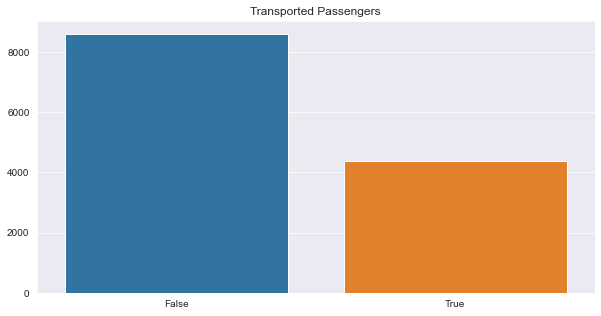

In [46]:
plt.figure(figsize=(10,5))
plt.title('Transported Passengers')
ax = sns.countplot(data=spacetitanic, x='Transported')
ax.set(xlabel = None)
ax.set(ylabel = None)

### Visualizing passengers' home planets and destinations - where did they come from and where were they headed?

[Text(0, 0.5, '')]

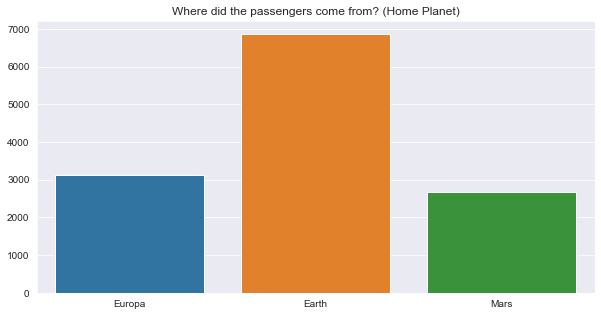

In [99]:
plt.figure(figsize=(10,5))
plt.title('Where did the passengers come from? (Home Planet)')
ax = sns.countplot(data=spacetitanic, x='HomePlanet')
ax.set(xlabel = None)
ax.set(ylabel = None)

Most of the passengers which boarded the spaceship came from Earth. There are roughly about the same amount of passengers that came from Europa and Mars.

[Text(0, 0.5, '')]

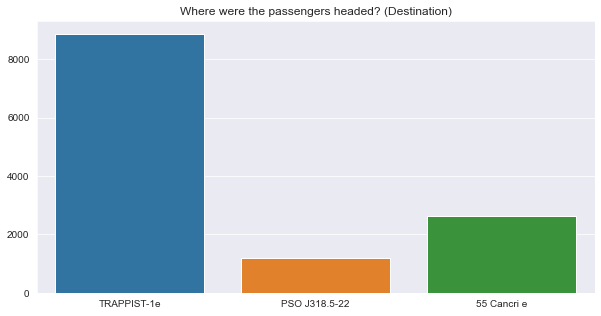

In [100]:
plt.figure(figsize=(10,5))
plt.title('Where were the passengers headed? (Destination)')
ax = sns.countplot(data=spacetitanic, x='Destination')
ax.set(xlabel = None)
ax.set(ylabel = None)

Most of the passengers which boarded the spaceship were headed to the TRAPPIST-1e exoplanet. 

### Visualizing the number of passengers in cryosleep vs. non-cryosleep

In [55]:
spacetitanic['CryoSleep'].value_counts()

False    8079
True     4581
Name: CryoSleep, dtype: int64

In [71]:
CryoMask = spacetitanic['CryoSleep'] == True
InCryo = len(spacetitanic[CryoMask])

NotInCryoMask = spacetitanic['CryoSleep'] == False
NotCryo = len(spacetitanic[NotInCryoMask])

print(f"The difference between Non-Cryo and Cryo is {NotCryo - InCryo} people")

The difference between Non-Cryo and Cryo is 3498 people


[Text(3.200000000000003, 0.5, '')]

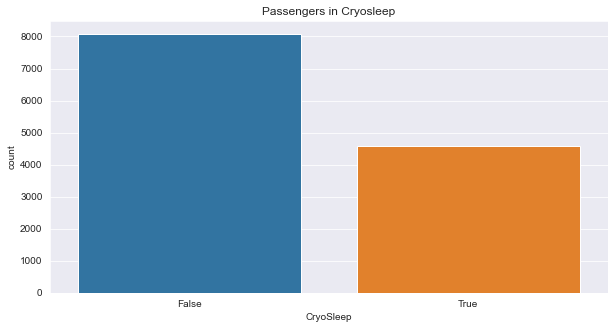

In [52]:
plt.figure(figsize=(10,5))
plt.title('Passengers in Cryosleep')
sns.countplot(data=spacetitanic, x='CryoSleep')
ax.set(xlabel = None)
ax.set(ylabel = None)

There were half as many passengers in wakefulness as there were that were in cryosleep. 

### Visualizing spending distribution (based on spending category column created earlier)

In [77]:
spacetitanic['spending_cat'].value_counts()

zero_spender        6221
moderate_spender    2901
heavy_spender       2901
light_spender        947
Name: spending_cat, dtype: int64

[Text(0, 0.5, '')]

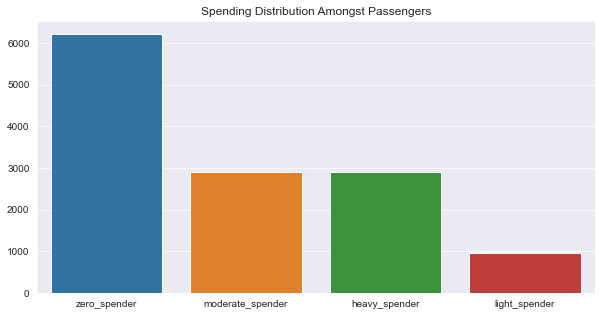

In [43]:
plt.figure(figsize=(10,5))
plt.title('Spending Distribution Amongst Passengers')
ax = sns.countplot(data=spacetitanic, x='spending_cat')
ax.set(xlabel = None)
ax.set(ylabel = None)

There were quite a lot of passengers who did not spend any cash, and there is quite literally the same amount of passengers who were moderate spenders and heavy spenders. The suspicion espoused earlier when cleaning data is that most of the zero spenders were on cryosleep. We will check this assumption:

In [95]:
spacetitanic.groupby('CryoSleep')['total_spending'].agg(['min','max','median','mean'])

,min,max,median,mean
CryoSleep,,,,
False,0.0,35987.0,924.0,2064.355985
True,0.0,0.0,0.0,0.000000


Indeed, everyone who was on cryosleep were zero spenders (Which means when you're in cryosleep, there's no way that you can just wake up out of your own will and do something) However, there were also some passengers who were in wakefulness but did not spend anything.